# Model Optimization of EOPE T1 Classifier V6

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np

In [3]:
from src.utils.data_loader import get_train_validation_input
from src.utils.data_loader import load_configuration_yaml
from src.utils.data_loader import save_predictor

In [4]:
from src.utils.model_optimizer.optimizer import get_best_params_cv
from src.utils.model_optimizer.optimizer import get_f1_score_loo
from src.utils.model_optimizer.optimizer import get_f1_score_cfv
from src.utils.model_optimizer.optimizer import get_f1_score_oss
from src.utils.model_optimizer.optimizer import get_model_opotimal
from src.utils.model_optimizer.optimizer import get_f1_data
from src.utils.model_optimizer.optimizer import get_prediction_loo
from src.utils.model_optimizer.optimizer import get_metrics_splits_ic
from src.utils.model_optimizer.evaluator import calculate_metrics
from src.utils.model_optimizer.evaluator import print_confusion_matrix

In [5]:
from src.utils.modelling_plots.modelplots import model_evaluation_plots
from src.utils.modelling_plots.modelplots import auc_plot_test_val
from src.utils.modelling_plots.modelplots import auc_plot_loo_val

In [6]:
from sklearn.svm import SVC

from sklearn.linear_model import  Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from tabpfn import TabPFNClassifier

### Globals

In [7]:
type_PE = "EOPE"
time = "T1"
DATASET_NAME = "eope_t1"
FOLDER_SAVE = "/Users/migual/Documents/iPremom/Data/cfRNA/cfRNA-v6/data-modelling-optimization/optimal_models/EOPE_T1/"
PATH_INPUT = "/Users/migual/Documents/iPremom/Data/cfRNA/cfRNA-v6/data-modelling-optimization/EOPE_T1/"
path_cm = PATH_INPUT + "input_model_eope_ctr_t1_v6_36g_131024.csv"


In [8]:
CONFIG_PATH = "../../../config/model_optimizer/"

In [9]:
svm_config_file = CONFIG_PATH + "svc_config_parameters.yml"
lasso_config_file = CONFIG_PATH + "lasso_config_parameters.yml"
elasticnet_config_file = CONFIG_PATH + "elasticnet_config_parameters.yml"
xgb_config_file = CONFIG_PATH + "xgb_config_parameters.yml"
rf_config_file = CONFIG_PATH + "rf_config_parameters.yml"

### Input Data Loading

In [10]:
# Loading dicovery and validation datasets
x_train, y_train, x_val, y_val = get_train_validation_input(
    path_file_input=path_cm,
)

In [11]:
# Exploration of Datasets
shape_discovery = x_train.shape
shape_validation = x_val.shape
print(f"Total number of samples  {shape_discovery[0]+shape_validation[0]}")
print(f"Number samples discovery {shape_discovery[0]}")
print(f"Number samples validation {shape_validation[0]}")

Total number of samples  116
Number samples discovery 80
Number samples validation 36


In [12]:
print(f"Number of CONTROL samples in training and validation datasets: {list(y_train).count(0)} | {list(y_val).count(0)}")
print(f"Number of {type_PE} samples in training and validation datasets: {list(y_train).count(1)} | {list(y_val).count(1)}")
print(f"Number of genes in training and validation datasets: {x_train.shape[1]} | {x_val.shape[1]}")

Number of CONTROL samples in training and validation datasets: 51 | 24
Number of EOPE samples in training and validation datasets: 29 | 12
Number of genes in training and validation datasets: 36 | 36


In [13]:
NUMBER_GENES = x_train.shape[1]

In [14]:
train_proportions = round(100*(list(y_train)).count(1)/len(y_train), 2)
val_proportions = round(100*(list(y_val)).count(1)/len(y_val), 2)

print(f"Proportion of {type_PE} in discovey dataset {train_proportions}%")
print(f"Proportion of {type_PE} in validation dataset {val_proportions}%")

Proportion of EOPE in discovey dataset 36.25%
Proportion of EOPE in validation dataset 33.33%


### Load Configuration Data

In [15]:
param_grid_svc = load_configuration_yaml(path_configuration_yaml=svm_config_file)
param_grid_lasso = load_configuration_yaml(path_configuration_yaml=lasso_config_file)
param_grid_elasticnet = load_configuration_yaml(path_configuration_yaml=elasticnet_config_file)
param_grid_xgb = load_configuration_yaml(path_configuration_yaml=xgb_config_file)
param_grid_rf = load_configuration_yaml(path_configuration_yaml=rf_config_file)

### Algorithm Optimization with Cross Fold Validation

In [16]:
alg_parameter_search = {"SVC": [SVC(), param_grid_svc],
                        "Lasso": [Lasso(), param_grid_lasso],
                        "ElasticNet": [ElasticNet(), param_grid_elasticnet],
                        "RandomForest": [RandomForestClassifier(), param_grid_rf],
                        "XGBoost": [XGBClassifier(), param_grid_xgb]
}

alg_best_parameters = {
    "TabPFNClassifier": None,
    "SVC": {},
    "Lasso": {},
    "ElasticNet": {},
    "RandomForest": {},
    "XGBoost": {},
}

In [17]:
for alg_name, alg in alg_parameter_search.items():
    best_parameters = get_best_params_cv(clf_algorithm=alg[0],
                                         parameters_search=alg[1],
                                         x_train=x_train,
                                         y_train=y_train,
                                         )
    alg_best_parameters[alg_name] = best_parameters

/Users/migual/Documents/iPremom/Repositories/tg-data-analysis-cfRNA/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.087e+00, tolerance: 1.473e-03
  model = cd_fast.enet_coordinate_descent(
/Users/migual/Documents/iPremom/Repositories/tg-data-analysis-cfRNA/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.517e+00, tolerance: 1.473e-03
  model = cd_fast.enet_coordinate_descent(
/Users/migual/Documents/iPremom/Repositories/tg-data-analysis-cfRNA/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Obje

### Algorithm Evaluation with LOO, CFV and OSS

In [18]:
alg_metrics = {"TabPFNClassifier": TabPFNClassifier,
                "SVC": SVC,
                "Lasso": Lasso,
                "ElasticNet": ElasticNet,
                "RandomForest": RandomForestClassifier,
                "XGBoost": XGBClassifier
}

alg_probabilities = {
    "TabPFNClassifier": True,
    "SVC": True,
    "Lasso": False,
    "ElasticNet": False,
    "RandomForest": True,
    "XGBoost": True,
}

alg_f1_metrics = {
    "TabPFNClassifier": [0, 0, 0, 0],   # F1 LOO, CFV, OSS, VAL
    "SVC": [0, 0, 0, 0], # F1 LOO, CFV, OSS, VAL
    "Lasso": [0, 0, 0, 0],    # F1 LOO, CFV, OSS, VAL
    "ElasticNet": [0, 0, 0, 0],   # F1 LOO, CFV, OSS, VAL
    "RandomForest": [0, 0, 0, 0], # F1 LOO, CFV, OSS, VAL
    "XGBoost": [0, 0, 0, 0],  # F1 LOO, CFV, OSS, VAL
}


In [19]:
for alg_name, alg in alg_metrics.items():
    f1_loo = get_f1_score_loo(alg,
                              alg_best_parameters[alg_name],
                              x_train,
                              y_train,
                              alg_probabilities[alg_name])
    f1_cfv = get_f1_score_cfv(alg,
                              alg_best_parameters[alg_name],
                              x_train,
                              y_train,
                              alg_probabilities[alg_name])
    f1_oss = get_f1_score_oss(alg,
                              alg_best_parameters[alg_name],
                              x_train,
                              y_train,
                              alg_probabilities[alg_name])
    trained_clf, trained_thr = get_model_opotimal(alg,
                              alg_best_parameters[alg_name],
                              x_train,
                              y_train,
                              alg_probabilities[alg_name])
    f1_val = get_f1_data(trained_clf,
                         trained_thr,
                         x_val, y_val,
                         alg_probabilities[alg_name])
    alg_f1_metrics[alg_name] = [round(100*f1_loo),
                                round(100*f1_cfv),
                                round(100*f1_oss), 
                                round(100*f1_val)]
    
    

/Users/migual/Documents/iPremom/Repositories/tg-data-analysis-cfRNA/.venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/Users/migual/Documents/iPremom/Repositories/tg-data-analysis-cfRNA/.venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on

In [20]:
# Result prints 
for alg_name, f1_metrics in alg_f1_metrics.items():
    print(f"{alg_name}: F1 LOO {f1_metrics[0]} | F1 CFV {f1_metrics[1]}  | F1 OSS {f1_metrics[2]} ")

TabPFNClassifier: F1 LOO 86 | F1 CFV 65  | F1 OSS 62 
SVC: F1 LOO 81 | F1 CFV 77  | F1 OSS 88 
Lasso: F1 LOO 73 | F1 CFV 66  | F1 OSS 86 
ElasticNet: F1 LOO 70 | F1 CFV 69  | F1 OSS 82 
RandomForest: F1 LOO 61 | F1 CFV 44  | F1 OSS 71 
XGBoost: F1 LOO 43 | F1 CFV 35  | F1 OSS 40 


### Visualization of Model Optimization

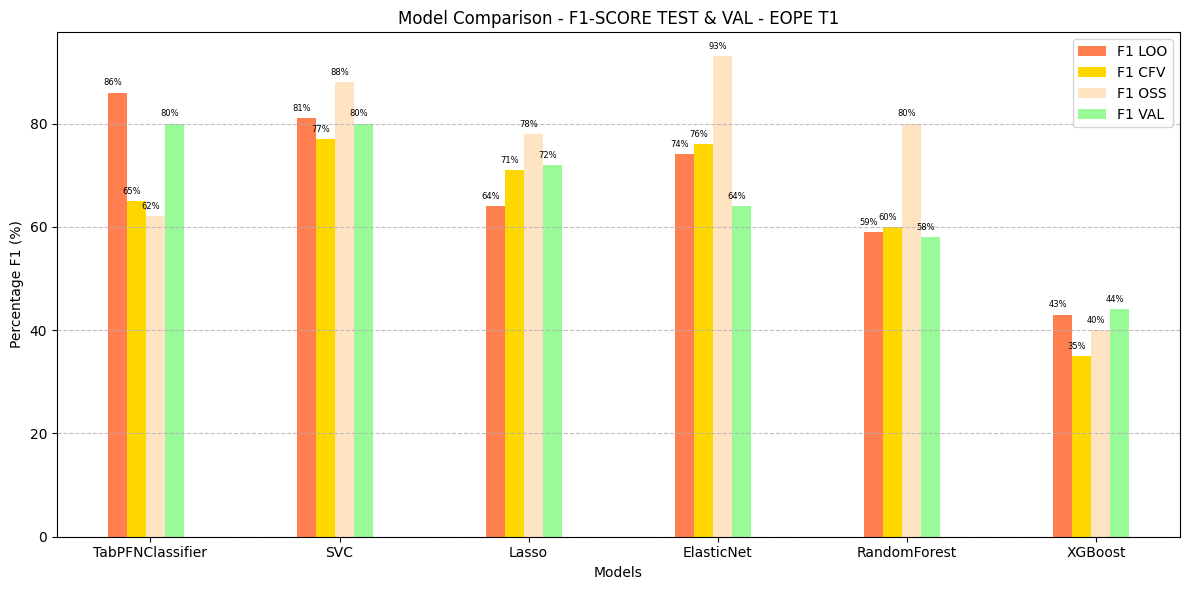

In [21]:
model_evaluation_plots(alg_f1_metrics, "EOPE T1")

### Final Model training

In [20]:
chosen_alg = "TabPFNClassifier"

In [21]:
y_pred_loo, test_scores_loo, trained_thr = get_prediction_loo(
    alg_metrics[chosen_alg],
    alg_best_parameters[chosen_alg],
    x_train,
    y_train,
    True)
test_metrics_loo = get_metrics_splits_ic(y_train, np.array(y_pred_loo))

/Users/migual/Documents/iPremom/Repositories/tg-data-analysis-cfRNA/.venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/Users/migual/Documents/iPremom/Repositories/tg-data-analysis-cfRNA/.venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on

In [22]:
trained_clf, trained_thr = get_model_opotimal(clf_algorithm=alg_metrics[chosen_alg],
                                              params_algorithm=alg_best_parameters[chosen_alg],
                                              x_train=x_train,
                                              y_train=y_train,
                                              bool_probabilities=alg_probabilities[chosen_alg])

/Users/migual/Documents/iPremom/Repositories/tg-data-analysis-cfRNA/.venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


In [23]:
val_probs = trained_clf.predict_proba(x_val)[:,1]
val_metrics = calculate_metrics(np.array(y_val), val_probs, trained_thr)

/Users/migual/Documents/iPremom/Repositories/tg-data-analysis-cfRNA/.venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


In [24]:
print("#### LEAVE ONE OUT METRICS ####")
for metric, value in test_metrics_loo.items():
    print(f"\t{metric}: {value[0]} +/- {value[1]}")

#### LEAVE ONE OUT METRICS ####
	Accuracy: 89 +/- 7.99
	Recall: 80 +/- 15.8
	F1_Score: 83 +/- 12.83
	AUC: 86 +/- 9.43
	Specificity: 90 +/- 7.23
	Precision: 88 +/- 12.83
	PPV: 80 +/- 15.8
	NPV: 92 +/- 8.47
	FDR: 20 +/- 15.8


In [25]:
print("#### LEAVE ONE OUT CM ####")
print_confusion_matrix(y_train, test_scores_loo, trained_thr)

#### LEAVE ONE OUT CM ####
TN: 47
FP: 4
FN: 5
TP: 24


In [26]:
print("#### VALIDATION METRICS ####")
for metric, value in val_metrics.items():
    print(f"\t{metric}: {value}")

print("#### VALIDATION CM ####")
print_confusion_matrix(y_val, val_probs, trained_thr)

#### VALIDATION METRICS ####
	Accuracy: 86
	Recall: 83
	F1_Score: 80
	AUC: 85
	Specificity: 91
	Precision: 77
	PPV: 83
	NPV: 88
	FDR: 17
#### VALIDATION CM ####
TN: 21
FP: 3
FN: 2
TP: 10


In [27]:
y_val_list = list(y_val)
y_disc = list(y_train)
print(f"TOTAL DISCOVERY {len(y_disc)}, CTR {y_disc.count(0)}, EOPE {y_disc.count(1)}")
print(f"TOTAL VAL {len(y_val_list)}, CTR {y_val_list.count(0)}, EOPE {y_val_list.count(1)}")

TOTAL DISCOVERY 80, CTR 51, EOPE 29
TOTAL VAL 36, CTR 24, EOPE 12


### AUC Final Model

SHAPE:  (21, 12)
SHAPE:  (21, 12)


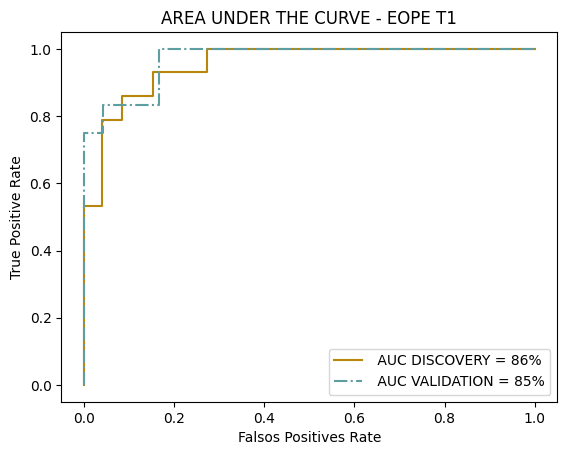

In [31]:
auc_plot_loo_val(y_test=y_train,
                 y_test_scores=test_scores_loo,
                 y_val=y_val,
                 y_val_scores=val_probs,
                 dataset_name="EOPE T1",
                 auc_test=test_metrics_loo["AUC"][0],
                 auc_val=val_metrics["AUC"],
                 num_splits=2)

### Saving trained model

In [30]:
save_predictor(trained_clf=trained_clf,
               trained_thr=trained_thr,
               path_folder_save=FOLDER_SAVE,
               num_variables=NUMBER_GENES,
               dataset_name=DATASET_NAME)

/Users/migual/Documents/iPremom/Repositories/tg-data-analysis-cfRNA/src/utils/data_loader.py:68: ResourceWarning: unclosed file <_io.BufferedWriter name='/Users/migual/Documents/iPremom/Data/cfRNA/cfRNA-v6/data-modelling-optimization/optimal_models/EOPE_T1//eope_t1_36_TabPFNClassifier_optimal_110424.sav'>
  pickle.dump(trained_clf, open(path_file_name, 'wb'))
